## Exploratory Data Analysis Code

In [1]:
import pandas as pd

import numpy as np
from tqdm import tqdm 
import os
from glob import glob
import matplotlib.pyplot as plt


In [2]:
# import selection peptides

def get_dataset(sel='./', anti='./', header=None):
    print(sel, anti)
    def get_df(location):
        if os.path.isdir(location):
            sdf = []
            files = [y for x in os.walk(location) for y in glob(os.path.join(x[0], '*.csv'))]
            if header is None:
                sdf = pd.concat([pd.read_csv(os.path.join(location, f), header=header) for f in files])
            else:
                sdf = pd.concat([pd.read_csv(os.path.join(location, f)) for f in files])
        else:
            if header is None:
                sdf = pd.read_csv(location, header=header)
            else:
                sdf = pd.read_csv(location)
        if header is None:
            sdf.columns = ['seq', None]
        sdf = sdf.drop_duplicates(subset=['seq'])
        return sdf

    sdf = get_df(sel)
    adf = get_df(anti)
    print('Unique peptides in sele (%s) and anti (%s) datasets!' % (str(sdf.shape[0]), str(adf.shape[0])))

    inter = np.intersect1d(sdf.seq.values, adf.seq.values)
    print('Intersection peptides:', inter.shape[0])
    sdf = sdf.loc[~sdf.seq.isin(inter)]
    adf = adf.loc[~adf.seq.isin(inter)]
    
    return sdf, adf

# spath = '/proj/kuhl_lab/users/dieckhau/LynD-substrate-modeling/LynD-substrate-modeling/data/csv/NNK7/rd1/sele/'
# apath = '/proj/kuhl_lab/users/dieckhau/LynD-substrate-modeling/LynD-substrate-modeling/data/csv/NNK7/rd1/anti/'

# spath = '/proj/kuhl_lab/users/dieckhau/LynD-substrate-modeling/LynD-substrate-modeling/data/csv/NNK7/rd2/sele/'
# apath = '/proj/kuhl_lab/users/dieckhau/LynD-substrate-modeling/LynD-substrate-modeling/data/csv/NNK7/rd2/anti/'

spath = '/proj/kuhl_lab/users/dieckhau/LynD-substrate-modeling/LynD-substrate-modeling/data/csv/NNK7/rd3/sele/'
apath = '/proj/kuhl_lab/users/dieckhau/LynD-substrate-modeling/LynD-substrate-modeling/data/csv/NNK7/rd3/anti/'

# spath = '/proj/kuhl_lab/users/dieckhau/LynD-substrate-modeling/LynD-substrate-modeling/data/csv/NNK6/sele/'
# apath = '/proj/kuhl_lab/users/dieckhau/LynD-substrate-modeling/LynD-substrate-modeling/data/csv/NNK6/anti/'

sel, anti = get_dataset(spath, apath, header=1)

/proj/kuhl_lab/users/dieckhau/LynD-substrate-modeling/LynD-substrate-modeling/data/csv/NNK7/rd3/sele/ /proj/kuhl_lab/users/dieckhau/LynD-substrate-modeling/LynD-substrate-modeling/data/csv/NNK7/rd3/anti/
Unique peptides in sele (469867) and anti (491952) datasets!
Intersection peptides: 187


In [3]:
"""
# trim out fixed regions to only include variable regions
indexing: 
    22-24: variable region 1

    25: target cysteine (fixed)
    26-28: variable region 2
"""

def trim_seq(df, pos_ranges=[[22, 25], [26, 29]]):
    if pos_ranges is None:
        df['var_seq'] = df['seq']
    elif len(pos_ranges) == 1:
        df['var_seq'] = df['seq'].str[pos_ranges[0][0]: pos_ranges[0][1]]
    else:
        df['var_seq'] = df['seq'].str[pos_ranges[0][0]: pos_ranges[0][1]] + df['seq'].str[pos_ranges[1][0]: pos_ranges[1][1]]
    return df
    
# for LynD NNK6
# pr = [[22, 25], [26, 29]]
# pr = [[22, 29]]

# for LynD NNK7
pr = [[14, 22]]
    
sel = trim_seq(sel, pr)
anti = trim_seq(anti, pr)

In [4]:

def filter_library(df, filter_seq='C1-4', flip=False):
    """Filter library according to amino acid presence at certain position(s)"""
    aa = filter_seq[0]
    pos = filter_seq[1:].split('-')
    pos = [int(p) for p in pos]

    mask = df['var_seq'].str[pos[0] - 1: pos[1]].str.contains(aa)

    if flip:
        return df.loc[mask].reset_index(drop=True)
    else:
       return df.loc[~mask].reset_index(drop=True)

tag = 'C1-4'
sel = filter_library(sel, tag, flip=False)
anti = filter_library(anti, tag, flip=False)


In [5]:
# train/test split for Y-star / S-score calculation

from sklearn.model_selection import train_test_split
sel_train, sel_test = train_test_split(sel, test_size=0.10)
anti_train, anti_test = train_test_split(anti, test_size=0.10)


In [6]:
# calculate y_star score (relative enrichment of certain residue/position combos)


def y_star_score(sel_df, anti_df):
    """
    y-star score for a library of NGS counts
    Formula obtained from https://pubs.acs.org/doi/10.1021/acscentsci.2c00223
    Serves as an expression of favorability of a specific amino acid / position based on SSM / NGS data
    """
    
    def y_star_single(sel_df, anti_df, p, aa):
        # alphabet = 'ACDEFGHIKLMNPQRSTVWY'
        alphabet = 'AVLIMCSTNQGPFYWHKRDE'
        f_sel = sel_df.loc[sel_df['var_seq'].str[p] == alphabet[aa]]['count'].sum() / sel_df['count'].sum()
        f_anti = anti_df.loc[anti_df['var_seq'].str[p] == alphabet[aa]]['count'].sum() / anti_df['count'].sum()
        return f_sel / f_anti
    
    seqs = sel_df['var_seq'].values
    pos_idx = len(seqs[0])
    aa_idx = 20
    y_star = np.zeros((pos_idx, aa_idx))
    
    for p in tqdm(range(pos_idx)):
        for aa in range(aa_idx):
            y_star[p, aa] = y_star_single(sel_df, anti_df, p, aa)    
    return y_star

y_star = y_star_score(sel_train, anti_train)
# y_star = y_star_score(sel, anti)

  0%|          | 0/8 [00:00<?, ?it/s]/tmp/ipykernel_734156/3245888118.py:16: RuntimeWarning: invalid value encountered in scalar divide
  return f_sel / f_anti
100%|██████████| 8/8 [01:20<00:00, 10.06s/it]


Text(0, 0.5, 'Y* score (log2)')

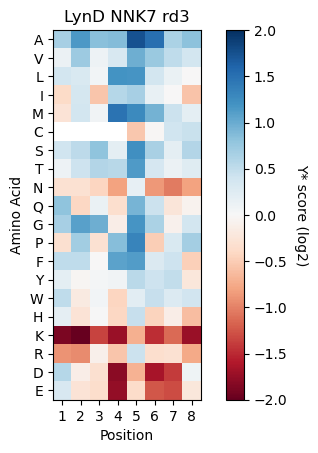

In [7]:
# plot as heatmap
alphabet = 'AVLIMCSTNQGPFYWHKRDE'

plt.imshow(np.log2(y_star.T), cmap='RdBu', vmin=-2, vmax=2)
plt.yticks(np.arange(len(alphabet)), alphabet)
plt.title('LynD NNK7 rd3')
plt.xticks(np.arange(y_star.shape[0]), np.arange(y_star.shape[0]) + 1)
plt.ylabel('Amino Acid')
plt.xlabel('Position')
cbar = plt.colorbar()

cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Y* score (log2)', rotation=270)

# plt.savefig('NNK7-YStar-rd3.pdf')

In [ ]:
# save Y star score as csv file

save_data = np.log2(y_star.T)
save_df = pd.DataFrame(data=save_data, columns=np.arange(1, 9), index=[a for a in alphabet])
save_df.to_csv('NNK7-YStar-rd3-C8.csv')

Text(0.5, 0, 'Threshold (S Score)')

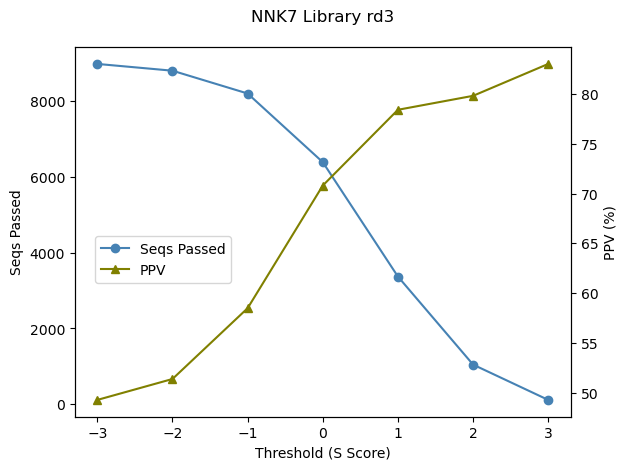

In [8]:
# make S Score plot

disp  = pd.DataFrame({
    'Seqs Passed': [8981, 8802, 8200, 6388, 3368, 1044, 112], 
    'Threshold': [-3, -2, -1, 0, 1, 2, 3], 
    'PPV': [49.3, 51.4, 58.5, 70.8, 78.4, 79.8, 83.0]
})

ax = disp.plot(x='Threshold', y='Seqs Passed', legend=False, color='steelblue', marker='o')
ax2 = ax.twinx()
disp.plot(x='Threshold', y='PPV', ax=ax2, legend=False, color='olive', marker='^')
ax.figure.legend(bbox_to_anchor=(0.38, 0.5, 0, 0))
plt.title('NNK7 Library rd3\n')
ax.set_ylabel('Seqs Passed')
ax2.set_ylabel('PPV (%)')
ax.set_xlabel('Threshold (S Score)')
# plt.savefig('NNK7-rd3-Sscore-PPV.pdf')
# plt.show()

In [9]:
# calculate S score for each peptide

def s_score(df, y_star):
    """
    S-score calculation for a specific peptide based on y_star scores for the library
    Formula obtained from https://pubs.acs.org/doi/10.1021/acscentsci.2c00223
    Serves as a (weak, naive) expression of peptide favorability, but ignores epistatic effects    
    """
    alphabet = 'AVLIMCSTNQGPFYWHKRDE'
    y_star = np.log2(y_star)
    seqs = df['var_seq']
    s_scores = []
    # iterate over seqs
    for s in tqdm(seqs):
        y_list = []
        # iterate over positions
        flag = True
        for idx, aa in enumerate(s):
            try:
                y = y_star[idx, alphabet.index(aa)]
                y_list.append(y)
            except ValueError:
                flag = False
                break
        if flag:
            s_scores.append(np.sum(y_list))
    return s_scores

s_sel = s_score(sel, y_star)
s_anti = s_score(anti, y_star)

# s_sel = s_score(sel_test, y_star)
# s_anti = s_score(anti_test, y_star)

# s_qc = s_score(qc, y_star)

100%|██████████| 190123/190123 [00:01<00:00, 99067.68it/s] 


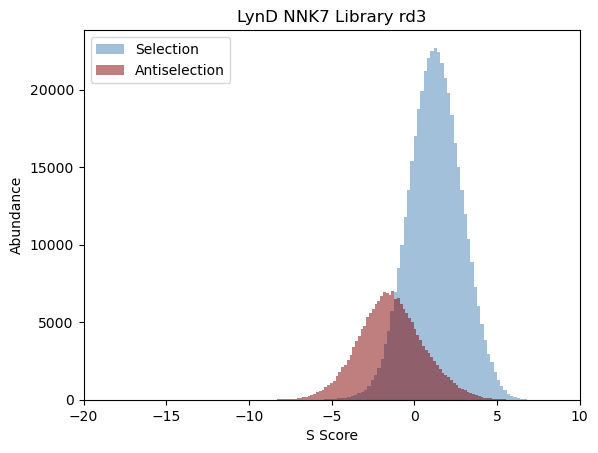

In [10]:
# plot  S Scores
plt.hist(s_sel, bins=100, color='steelblue', alpha=0.5)#, density=True)
plt.hist(s_anti, bins=100, color='maroon', alpha=0.5)#, density=True)
plt.xlim(-20, 10)
plt.title('LynD NNK7 Library rd3')
plt.xlabel('S Score')
plt.ylabel('Abundance')
plt.legend(['Selection', 'Antiselection'])
# plt.savefig('NNK7-rd3-SScore-dist.pdf')

In [ ]:
# threshold the S-score

df_sel = pd.DataFrame({
        'active': 1, 
        's_score': s_sel
    })
df_anti = pd.DataFrame({
    'active': 0, 
    's_score': s_anti
})

df = pd.concat([df_sel, df_anti], axis=0).reset_index(drop=True)

from sklearn.metrics import roc_curve
fpr, tpr, thresh = roc_curve(df.active.values, df.s_score.values)
idx = np.argmax(tpr - fpr)
opt_thr = thresh[idx]

In [ ]:
# CUSTOM = 1
CUSTOM = opt_thr
pred_pos = df.loc[df.s_score > CUSTOM] # keep only those with S-score above threshold ("predicted positives")
frac = pred_pos.loc[pred_pos.active == 1].shape[0] / pred_pos.shape[0] # get fraction of "true positives" vs total
num = pred_pos.loc[pred_pos.active == 1].shape[0]
print('TOTAL PEPTIDES:', num, '\nFPR:', frac)

In [ ]:
pred_active = df.s_score > opt_thr

from sklearn.metrics import accuracy_score, balanced_accuracy_score
accuracy_score(df.active, pred_active), balanced_accuracy_score(df.active, pred_active)

In [ ]:
# tmp = np.ones_like(pred_active)
tmp = np.random.choice([0, 1], size=df.active.shape[0])
accuracy_score(tmp, df.active)

In [ ]:
# 100 * (pred_active * df.active).sum() / pred_active.shape[0]
# 100 * ( (1 - pred_active) * (1 - df.active) ).sum() / pred_active.shape[0]

In [ ]:
# ---------- Hamming Distance ------------ #

from scipy.spatial.distance import hamming 


def hamming_lib(df, sub=0.1):
    """
    Calculates Hamming distance of all-vs-all for a peptide library as a rough seq diversity metric
    Note: this currently runs VERY slowly and can't handle more than a few thousand seqs
    """
    
    seqs = df.seq.values
    siz = round(seqs.shape[0] * sub)
    seqs = np.random.choice(seqs, siz)
    print(seqs.shape)
    ham_list = []
    for s1 in tqdm(seqs):
        for s2 in seqs:
            if s1 != s2:
                ham = hamming(list(s1), list(s2)) * len(s1)
                ham_list.append(ham)
    return ham_list

hams = hamming_lib(sel, 0.01)



In [ ]:
sel['var_seq'].head

In [ ]:
anti['var_seq'].head

In [ ]:
sel_test['s_score'] = s_sel
anti_test['s_score'] = s_anti

In [ ]:
import seaborn as sns
sns.histplot(sel_test, x='s_score', bins=100)

In [ ]:
low = sel_test.loc[sel_test['s_score'] < -0.5]
low['early_C'] = low['var_seq'].str[0:4].str.contains('C')

low.early_C.value_counts()

In [ ]:
low = anti_test.loc[anti_test['s_score'] < -0.5]
low['early_C'] = low['var_seq'].str[0:4].str.contains('C')
low.early_C.value_counts()